# Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

- Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

- Answer those questions through a mix of statistical tests and visualizations.

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

import env
import explore
import acquire
import summarize
from summarize import df_summary

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Acquire/Wrangle Data

In [4]:
df = acquire.get_zillow_data()

df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,nan,nan,nan,2.00,3.00,None,8.00,2.00,...,"60,371,132,321,007.00",-0.01,2017-07-07,None,None,None,Central,Single Family Residential,None,None
1,1072280,10711877,1.00,nan,nan,2.00,4.00,None,8.00,2.00,...,"60,371,132,321,007.00",0.02,2017-08-29,Central,None,None,Central,Single Family Residential,None,None
2,1340933,10711888,1.00,nan,nan,2.00,4.00,None,8.00,2.00,...,"60,371,132,321,007.00",0.08,2017-04-04,Central,None,None,Central,Single Family Residential,None,None
3,1878109,10711910,nan,nan,nan,2.00,3.00,None,8.00,2.00,...,"60,371,132,321,008.00",-0.04,2017-03-17,None,None,None,Central,Single Family Residential,None,None
4,2190858,10711923,nan,nan,nan,2.00,4.00,None,8.00,2.00,...,"60,371,132,321,008.00",-0.01,2017-03-24,None,None,None,Central,Single Family Residential,None,None


In [5]:
info, describe, nulls, value_count = df_summary (df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72236 entries, 0 to 72235
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            72236 non-null  int64  
 1   parcelid                      72236 non-null  int64  
 2   airconditioningtypeid         23078 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   72236 non-null  float64
 6   bedroomcnt                    72236 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         45079 non-null  float64
 9   calculatedbathnbr             71983 non-null  float64
 10  decktypeid                    612 non-null    float64
 11  finishedfloor1squarefeet      6030 non-null   float64
 12  calculatedfinishedsquarefeet  72051 non-null  float64
 13  f

In [6]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [7]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [8]:
# Function to read and wrangle data:

def wrangle_zillow():
    df = acquire.get_zillow_data()
    
    # Restrict df to only properties that meet single unit use criteria
    single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    
    # Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>350)]

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange', 
                                   'Ventura'))    
    # drop columns not needed
    df = remove_columns(df, ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc'])


    # replace nulls in unitcnt with 1
    df.unitcnt.fillna(1, inplace = True)
    
    # assume that since this is Southern CA, null means 'None' for heating system
    df.heatingorsystemdesc.fillna('None', inplace = True)
    
    # replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7313, inplace = True)
    df.buildingqualitytypeid.fillna(6.0, inplace = True)

    # Columns to look for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df[df.calculatedfinishedsquarefeet < 8000]
    df[df.lotsizesquarefeet < 8000] # = to 1 acre
    
    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    
    return df

In [9]:
df = wrangle_zillow()
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county
0,10711855,2.00,3.00,8.00,"2,107.00","6,037.00","34,222,559.00","-118,617,387.00","9,158.00","60,371,132.32",...,"1,972.00","249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles
1,10711877,2.00,4.00,8.00,"1,882.00","6,037.00","34,220,261.00","-118,616,409.00","9,035.00","60,371,132.32",...,"1,972.00","253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles
2,10711888,2.00,4.00,8.00,"1,882.00","6,037.00","34,222,491.00","-118,616,854.00","9,800.00","60,371,132.32",...,"1,972.00","257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles
3,10711910,2.00,3.00,8.00,"1,477.00","6,037.00","34,221,864.00","-118,615,739.00","11,285.00","60,371,132.32",...,"1,960.00","57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles
4,10711923,2.00,4.00,8.00,"1,918.00","6,037.00","34,220,619.00","-118,615,253.00","11,239.00","60,371,132.32",...,"1,960.00","167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles


In [10]:
df.shape

(69730, 25)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69730 entries, 0 to 72214
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      69730 non-null  int64  
 1   bathroomcnt                   69730 non-null  float64
 2   bedroomcnt                    69730 non-null  float64
 3   buildingqualitytypeid         69730 non-null  float64
 4   calculatedfinishedsquarefeet  69730 non-null  float64
 5   fips                          69730 non-null  float64
 6   latitude                      69730 non-null  float64
 7   longitude                     69730 non-null  float64
 8   lotsizesquarefeet             69730 non-null  float64
 9   rawcensustractandblock        69730 non-null  float64
 10  regionidcity                  69730 non-null  float64
 11  regionidcounty                69730 non-null  float64
 12  regionidzip                   69730 non-null  float64
 13  r

In [12]:
# Lotsizesquarefeet Outliers

q1 = df.lotsizesquarefeet.quantile(.25)
q3 = df.lotsizesquarefeet.quantile(.75)

iqr = q3 - q1

multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

# Let's filter out the low outliers
df = df[df.lotsizesquarefeet > lower_bound]
# lets say give us everyhting less than the upper bound
df = df[df.lotsizesquarefeet < upper_bound]
df.shape

(57965, 25)

In [13]:
# Bathroomcnt Outliers

q1 = df.bathroomcnt.quantile(.25)
q3 = df.bathroomcnt.quantile(.75)

iqr = q3 - q1

multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

# Let's filter out the low outliers
df = df[df.bathroomcnt > lower_bound]
# lets say give us everyhting less than the upper bound
df = df[df.bathroomcnt < upper_bound]
df.shape

(56613, 25)

In [14]:
# Bedroomcnt Outliers

q1 = df.bedroomcnt.quantile(.25)
q3 = df.bedroomcnt.quantile(.75)

iqr = q3 - q1

multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

# Let's filter out the low outliers
df = df[df.bedroomcnt > lower_bound]
# lets say give us everyhting less than the upper bound
df = df[df.bedroomcnt < upper_bound]
df.shape

(56568, 25)

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Prep Data 

In [16]:
con_vars = ['transactiondate', 'taxamount', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt','roomcnt','lotsizesquarefeet','longitude','latitude','fips', 'calculatedfinishedsquarefeet', 'bedroomcnt','bathroomcnt']

In [17]:
def scale_my_data(train, validate, test):
    scaler = StandardScaler()
    scaler.fit(train[['roomcnt','lotsizesquarefeet','longitude','latitude','fips', 'calculatedfinishedsquarefeet', 'bedroomcnt','bathroomcnt']])
    X_train_scaled = scaler.transform(train[['roomcnt','lotsizesquarefeet','longitude','latitude','fips', 'calculatedfinishedsquarefeet', 'bedroomcnt','bathroomcnt']])
    X_validate_scaled = scaler.transform(validate[['roomcnt','lotsizesquarefeet','longitude','latitude','fips', 'calculatedfinishedsquarefeet', 'bedroomcnt','bathroomcnt']])
    X_test_scaled = scaler.transform(test[['roomcnt','lotsizesquarefeet','longitude','latitude','fips', 'calculatedfinishedsquarefeet', 'bedroomcnt','bathroomcnt']])

    train[['roomcnt_scaled','lotsizesquarefeet_scaled','longitude_scaled','latitude_scaled','fips_scaled', 'calculatedfinishedsquarefeet_scaled', 'bedroomcnt_scaled','bathroomcnt_scaled']] = X_train_scaled
    validate[['roomcnt_scaled','lotsizesquarefeet_scaled','longitude_scaled','latitude_scaled','fips_scaled', 'calculatedfinishedsquarefeet_scaled', 'bedroomcnt_scaled','bathroomcnt_scaled']] = X_validate_scaled
    test[['roomcnt_scaled','lotsizesquarefeet_scaled','longitude_scaled','latitude_scaled','fips_scaled', 'calculatedfinishedsquarefeet_scaled', 'bedroomcnt_scaled','bathroomcnt_scaled']] = X_test_scaled
    
    return train, validate, test

def prep_mall(df):
    '''
    dummy var for gender into is_male
    add 'spending_class' that cut spending score into the 4 quartiles and label the new field by q1, q2, q3, q4. 
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    
    train, validate, test = explore.train_validate_test_split(df, target='logerror', seed=123)
    train, validate, test = scale_my_data(train, validate, test)
        
    return df, train, validate, test

In [18]:
df, train, validate, test = prep_mall(df)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,heatingorsystemdesc,county,roomcnt_scaled,lotsizesquarefeet_scaled,longitude_scaled,latitude_scaled,fips_scaled,calculatedfinishedsquarefeet_scaled,bedroomcnt_scaled,bathroomcnt_scaled
62691,14666277,2.00,3.00,6.00,"1,460.00","6,059.00","33,623,091.00","-117,736,548.00","7,313.00","60,590,626.21",...,Yes,Orange,1.41,0.07,1.18,-1.33,0.38,-0.30,-0.04,-0.18
56966,14404196,3.00,3.00,6.00,"2,004.00","6,059.00","33,537,540.00","-117,760,471.00","12,000.00","60,590,626.20",...,None,Orange,1.75,1.80,1.11,-1.64,0.38,0.51,-0.04,1.15
14389,11314424,2.00,4.00,6.00,"1,204.00","6,037.00","34,710,000.00","-118,124,910.00","7,313.00","60,379,006.02",...,Central,Los_Angeles,-0.60,0.07,0.13,2.68,-0.65,-0.68,1.06,-0.18
61728,14642354,3.00,3.00,6.00,"2,152.00","6,059.00","33,695,914.00","-117,745,396.00","7,313.00","60,590,524.18",...,None,Orange,-0.60,0.07,1.16,-1.06,0.38,0.73,-0.04,1.15
18323,11553424,4.00,3.00,9.00,"3,036.00","6,037.00","34,017,397.00","-118,441,376.00","6,048.00","60,372,715.00",...,Central,Los_Angeles,-0.60,-0.39,-0.73,0.13,-0.65,2.05,-0.04,2.48


In [19]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Exploration

In [20]:
binary_vars = ['bedroomcnt', 'bathroomcnt']
quant_vars = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'buildingqualitytypeid', 'bedroomcnt', 'bathroomcnt']
categorical_target = 'fips'
continuous_target = 'logerror'

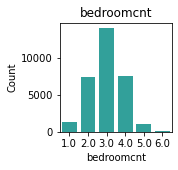

               bedroomcnt  Count              Percent
3.00                 3.00  14090                44.48
4.00                 4.00   7586                23.95
2.00                 2.00   7462                23.56
5.00                 1.00   1347                 4.25
1.00                 5.00   1026                 3.24
6.00                 6.00    166                 0.52
_________________________________________________________________


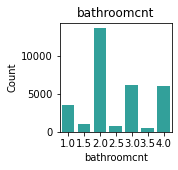

              bathroomcnt  Count              Percent
2.00                 2.00  13587                42.89
3.00                 3.00   6204                19.59
1.00                 4.00   6055                19.11
2.50                 1.00   3575                11.29
4.00                 1.50   1008                 3.18
1.50                 2.50    756                 2.39
3.50                 3.50    492                 1.55
_________________________________________________________________


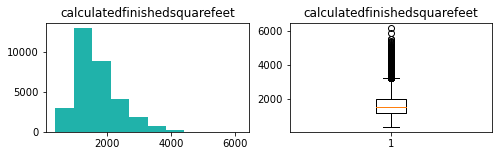

count              31,677.00
mean                1,662.53
std                   669.71
min                   360.00
25%                 1,186.00
50%                 1,516.00
75%                 2,005.00
max                 6,161.00
Name: calculatedfinishedsquarefeet, dtype: float64


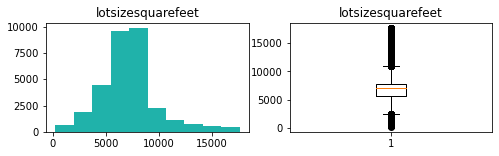

count              31,677.00
mean                7,113.85
std                 2,719.47
min                   236.00
25%                 5,675.00
50%                 7,054.00
75%                 7,779.00
max                17,667.00
Name: lotsizesquarefeet, dtype: float64


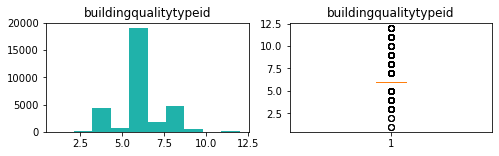

count              31,677.00
mean                    6.14
std                     1.26
min                     1.00
25%                     6.00
50%                     6.00
75%                     6.00
max                    12.00
Name: buildingqualitytypeid, dtype: float64


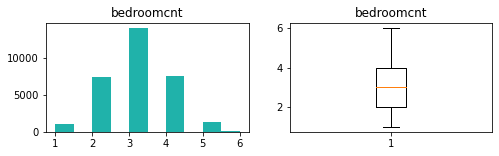

count              31,677.00
mean                    3.04
std                     0.91
min                     1.00
25%                     2.00
50%                     3.00
75%                     4.00
max                     6.00
Name: bedroomcnt, dtype: float64


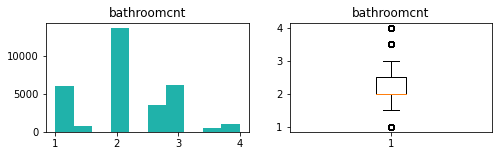

count              31,677.00
mean                    2.14
std                     0.75
min                     1.00
25%                     2.00
50%                     2.00
75%                     2.50
max                     4.00
Name: bathroomcnt, dtype: float64


In [21]:
explore.explore_univariate(train, binary_vars, quant_vars)

## Takeaways

- 63.17 percent of the properties are located in a fips of 6037
- The mean of calcualted finished square feet is 1,737.22 sq/ft
- With major outliers removed the mean loitsize square feet is 7,169.83 which is roughly 0.16 of an acre.

bedroomcnt 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=0.0, pvalue=0.0)
                  chi2              p-value  degrees of freedom
0               362.55                 0.00                  10

observed:
 fips        6037.0  6059.0  6111.0    All
bedroomcnt                               
1.0            429     526      71   1026
2.0           4377    2542     543   7462
3.0           8677    4264    1149  14090
4.0           4083    2618     885   7586
5.0            741     443     163   1347
6.0             97      56      13    166
All          18404   10449    2824  31677

expected:
                      0                    1                    2
0               596.10               338.44                91.47
1             4,335.34             2,461.42               665.24
2             8,186.14             4,647.74             1,256.12
3             4,407.39             2,502.32               676.29
4               782.59     

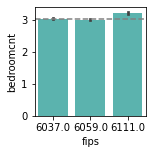


_____________________

bathroomcnt 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=0.0, pvalue=0.0)
                  chi2              p-value  degrees of freedom
0             8,318.71                 0.00                  12

observed:
 fips         6037.0  6059.0  6111.0    All
bathroomcnt                               
1.0            4726    1038     291   6055
1.5               0     615     141    756
2.0            8653    3817    1117  13587
2.5               0    2867     708   3575
3.0            4230    1548     426   6204
3.5               0     401      91    492
4.0             795     163      50   1008
All           18404   10449    2824  31677

expected:
                      0                    1                    2
0             3,517.89             1,997.31               539.80
1               439.23               249.37                67.40
2             7,893.90             4,481.82             1,211.28
3             2

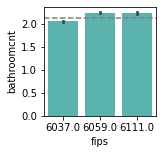


_____________________

calculatedfinishedsquarefeet 
____________________



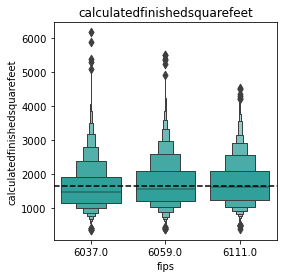

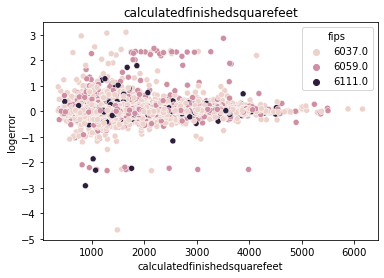

fips              6,037.00             6,059.00             6,111.00
count            18,404.00            10,449.00             2,824.00
mean              1,620.89             1,716.75             1,733.31
std                 652.02               697.22               659.40
min                 360.00               380.00               400.00
25%               1,161.00             1,210.00             1,241.00
50%               1,480.00             1,562.00             1,612.00
75%               1,927.00             2,103.00             2,090.00
max               6,161.00             5,503.00             4,519.00 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.06143975876226582, pvalue=7.023500050518772e-28)

____________________

lotsizesquarefeet 
____________________



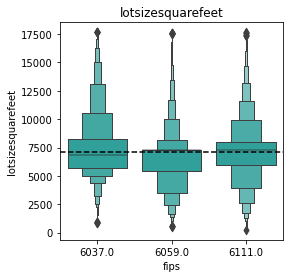

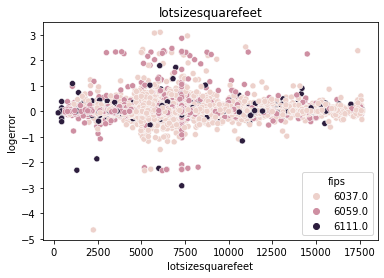

fips              6,037.00             6,059.00             6,111.00
count            18,404.00            10,449.00             2,824.00
mean              7,436.43             6,557.73             7,069.26
std               2,827.01             2,411.71             2,744.41
min                 865.00               480.00               236.00
25%               5,724.00             5,400.00             5,987.25
50%               6,865.50             7,313.00             7,313.00
75%               8,240.00             7,313.00             8,000.00
max              17,667.00            17,600.00            17,645.00 


Spearman's Correlation Test:
 SpearmanrResult(correlation=-0.0031881675398470173, pvalue=0.570435535055353)

____________________

buildingqualitytypeid 
____________________



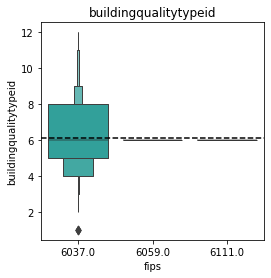

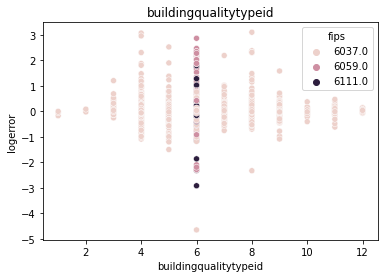

fips              6,037.00             6,059.00             6,111.00
count            18,404.00            10,449.00             2,824.00
mean                  6.24                 6.00                 6.00
std                   1.65                 0.00                 0.00
min                   1.00                 6.00                 6.00
25%                   5.00                 6.00                 6.00
50%                   6.00                 6.00                 6.00
75%                   8.00                 6.00                 6.00
max                  12.00                 6.00                 6.00 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.006144472715800378, pvalue=0.2741469099973939)

____________________

bedroomcnt 
____________________



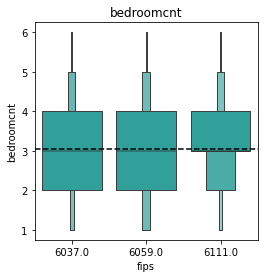

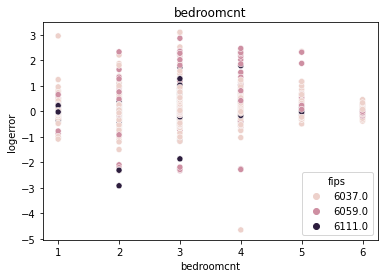

fips              6,037.00             6,059.00             6,111.00
count            18,404.00            10,449.00             2,824.00
mean                  3.03                 3.01                 3.20
std                   0.87                 0.96                 0.92
min                   1.00                 1.00                 1.00
25%                   2.00                 2.00                 3.00
50%                   3.00                 3.00                 3.00
75%                   4.00                 4.00                 4.00
max                   6.00                 6.00                 6.00 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.04206232022587774, pvalue=6.924994290266543e-14)

____________________

bathroomcnt 
____________________



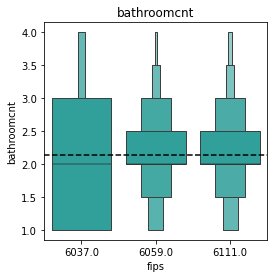

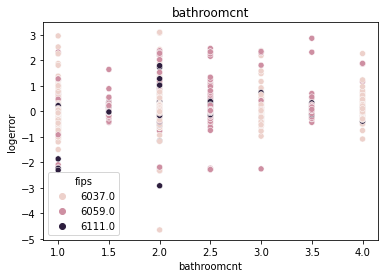

fips              6,037.00             6,059.00             6,111.00
count            18,404.00            10,449.00             2,824.00
mean                  2.06                 2.25                 2.23
std                   0.81                 0.65                 0.65
min                   1.00                 1.00                 1.00
25%                   1.00                 2.00                 2.00
50%                   2.00                 2.00                 2.00
75%                   3.00                 2.50                 2.50
max                   4.00                 4.00                 4.00 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.05075017991520351, pvalue=1.5956210492446555e-19)

____________________



In [22]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

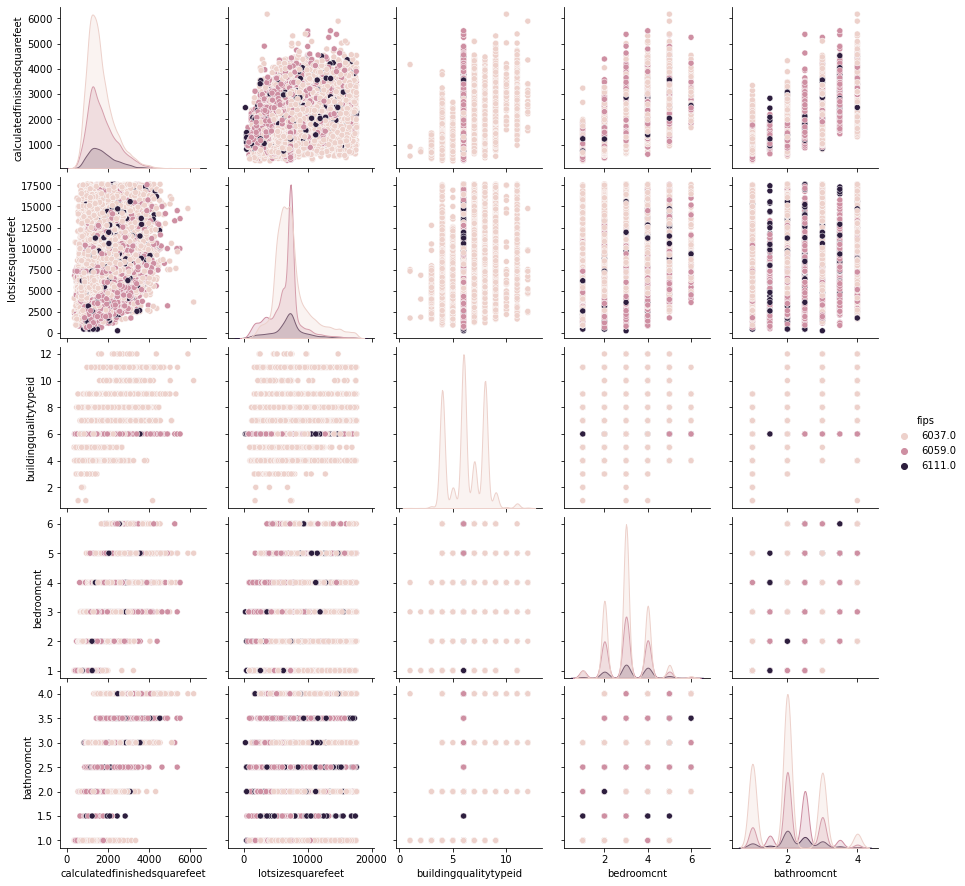

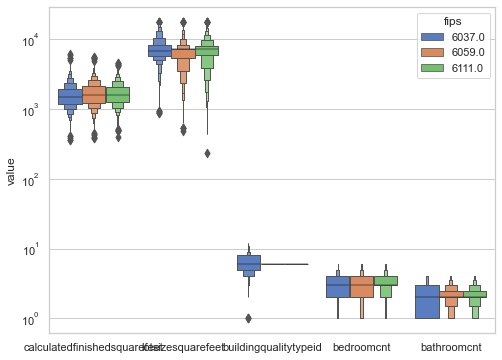

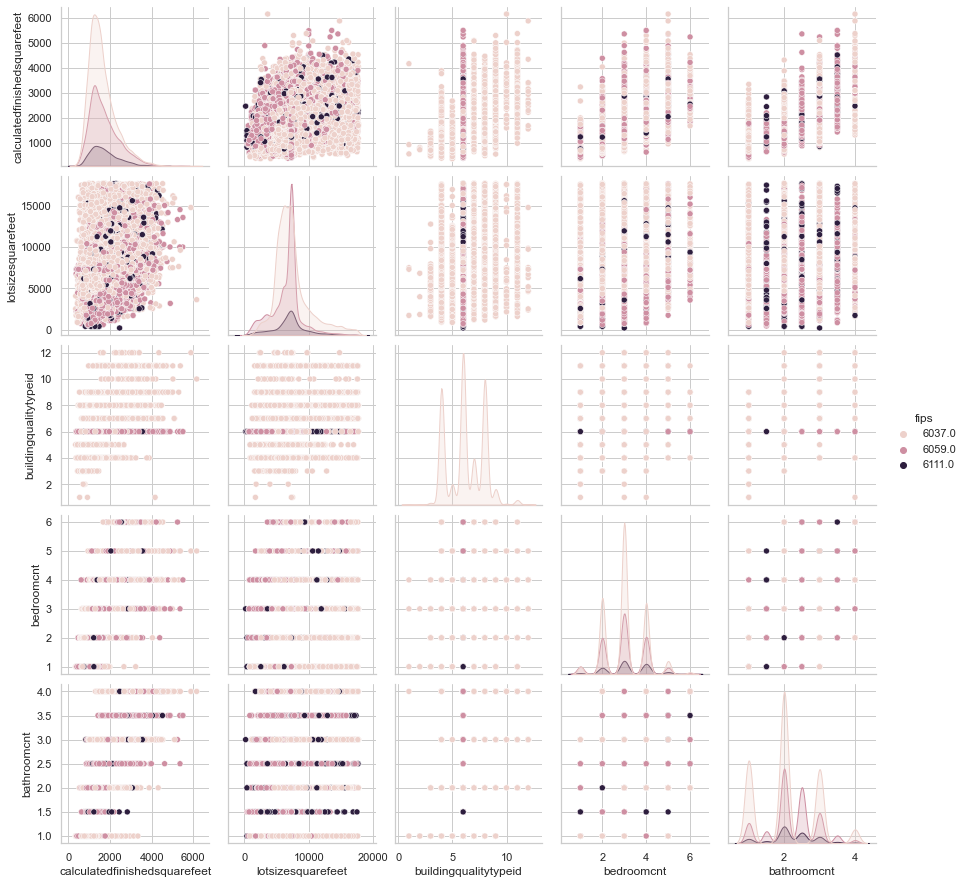

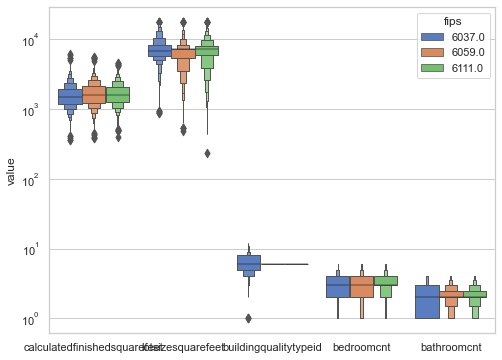

In [23]:
for var in binary_vars:
    explore.explore_multivariate(train, categorical_target, var, quant_vars)

## Takeaways

### Question 1 is there a significatn differance in logerror based on calculatedsquarefeet?
- With a p-value of 2.3134934775962534e-39 there does appear to be a significatn differance in logerror based on calculatedsquarefeet.

### Question 2 is there a significatn differance in logerror based on lotsizesquarefeet?
- With a p-value of 7.023500050518772e-28 there does appear to be a significatn differance in logerror based on lotsizesquarefeet.

### Question 3 is there a significatn differance in logerror based on bedroomcnt?
- With a p-value of 6.924994290266543e-14 there does appear to be a significatn differance in logerror based on bedroomcnt.

### Question 4 is there a significatn differance in logerror based on bathroomcnt?
- With a p-value of 1.5956210492446555e-19 there does appear to be a significatn differance in logerror based on bathroomcnt.

### Question 5 is there a significatn differance in logerror based on buildingqualitytypeid?
- With a p-value of .27 there does not appear to be a significatn differance in logerror based on buildingqualitytypeid.

## Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

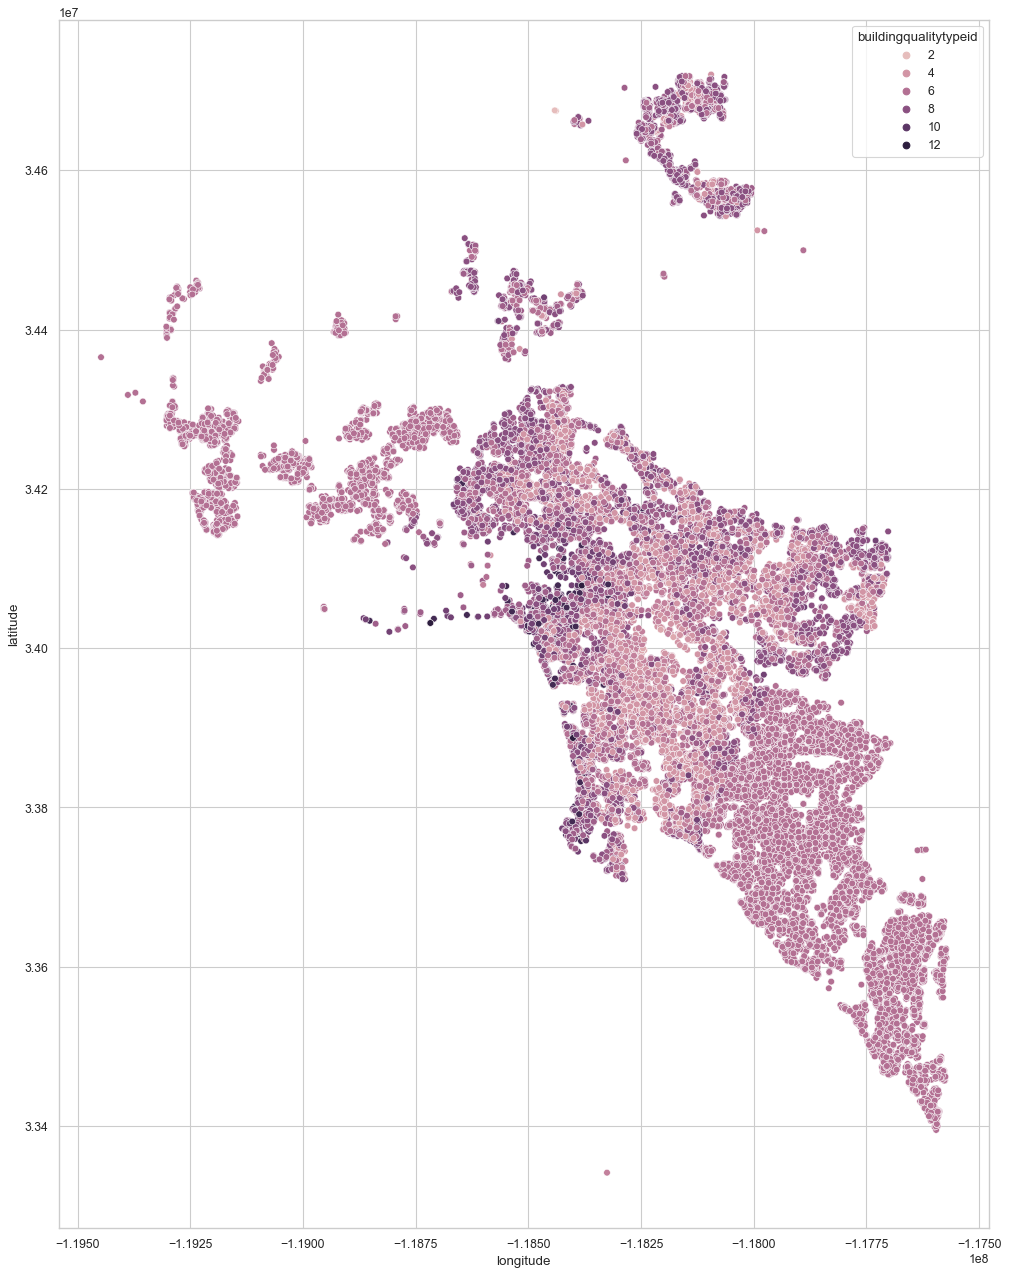

In [35]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15, 20), dpi=80)
sns.scatterplot(x = train.longitude, y = train.latitude, hue = train.buildingqualitytypeid)

## Takeaways

- Building quality ids within 2-4 are generalized in midtown/outskirts NE of LA. 
- Building quality ids within 6 are generalized in Orange County, and there seems ot be no high quality homes to the south or OC.
- Most of the High quality homes with ids of 8-12 are along the west coastline of LA and downtown LA.  